# Incremental Logistic Regression (Unbalanced Traffic)
Our previous model's success was predicated on having a large number of prelabeled data. In a real life environment, this is unrealistic; we only have the raw, unlabelled data that we observe over time, and almost certainly will not be able to hand-label half a million points.

In this notebook, we will simulate our logistic regression model's performance against a stream of mostly background events with sporadic malicious traffic. The CTU dataset has a relative occurrence of around .17%, so that is what we will emulate.

In [1]:
import string
import os
import pickle


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

from creme import stream
from creme import model_selection
from creme import compose
from creme import feature_extraction
from creme import linear_model
from creme import metrics
from creme import preprocessing
from creme import stats
from creme import anomaly

In [2]:
train_attack_types = pd.read_csv("datasets/training_attack_types.txt", delimiter=" ", header=None, names= ["attack_type", "attack_category"])

In [3]:
target = "back"
train_attack_types.loc[train_attack_types["attack_type"]==target, "attack_category"].values[0]

'dos'

In [4]:
cols = list(pd.read_csv("datasets/kddcup.names.txt", skiprows=1, header=None)[0].map(lambda x: str(x).split(":")[0]).values)
cols.append("label")


reduced_cols = cols[:9]
reduced_cols.append("label")

reduced_cols

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'label']

In [5]:
train = pd.read_csv("datasets/kddcup.data.corrected.txt", header=None, names=cols)

In [6]:
train = train[reduced_cols].copy()

In [7]:
test = pd.read_csv("datasets/corrected.txt", header=None, names=cols)

In [8]:
test = test[reduced_cols].copy()

In [9]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,tcp,http,SF,215,45076,0,0,0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,normal.
4,0,tcp,http,SF,239,486,0,0,0,normal.


In [10]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,udp,private,SF,105,146,0,0,0,normal.
1,0,udp,private,SF,105,146,0,0,0,normal.
2,0,udp,private,SF,105,146,0,0,0,normal.
3,0,udp,private,SF,105,146,0,0,0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,snmpgetattack.


# Preprocessing

## Process the label column
We want to remove the period. Then we want to generate three label columns:

In [11]:
train["label"] = train["label"].map(lambda x: x.split(".")[0])
test["label"] = test["label"].map(lambda x: x.split(".")[0])

### Binary label (normal/malicious)

In [12]:
train["label_binary"] = train["label"].map(lambda x: 0 if x=="normal" else 1)
test["label_binary"] = test["label"].map(lambda x: 0 if x=="normal" else 1)

In [13]:
test["label_binary"].value_counts()

1    250436
0     60593
Name: label_binary, dtype: int64

In [14]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

In [15]:
# X = pd.get_dummies(train, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary"])
train_shuffled = train.sample(frac=1).reset_index(drop=True)

# Subsampling


In [16]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

In [17]:
972781*0.0017

1653.7277

We'll sample 1500 instances from the positive class, shuffle it in with all of the negative class. 

In [18]:
train.shape

(4898431, 11)

In [19]:
test.shape

(311029, 11)

In [20]:
subsampled_malware = train.loc[train["label_binary"]==1].sample(1500)
background = train.loc[train["label_binary"]==0].iloc[250:]
warmup = train.loc[train["label_binary"]==0].iloc[:250]
df = pd.concat([subsampled_malware, background])

In [21]:
df = df.sample(frac=1).reset_index(drop=True)

# Streaming Logistic Regression (imbalanced traffic)
## Data stream
Here we will build our data stream

In [70]:
datastream = stream.iter_pandas(df.drop(columns=["label_binary", "label"]), df["label_binary"])
warmup_stream = stream.iter_pandas(warmup.drop(columns=["label_binary", "label"]), warmup["label_binary"])
# teststream = stream.iter_pandas(holdout.drop(columns=["label_binary", "label"]), holdout["label_binary"]

## Pipeline
We will scale and one-hot-encode.

In [71]:
train.dtypes

duration           int64
protocol_type     object
service           object
flag              object
src_bytes          int64
dst_bytes          int64
land               int64
wrong_fragment     int64
urgent             int64
label             object
label_binary       int64
dtype: object

In [72]:
cols_string = [col for col,col_type in zip(train.columns[:-2], train.dtypes[:-2]) if col_type == "object"]

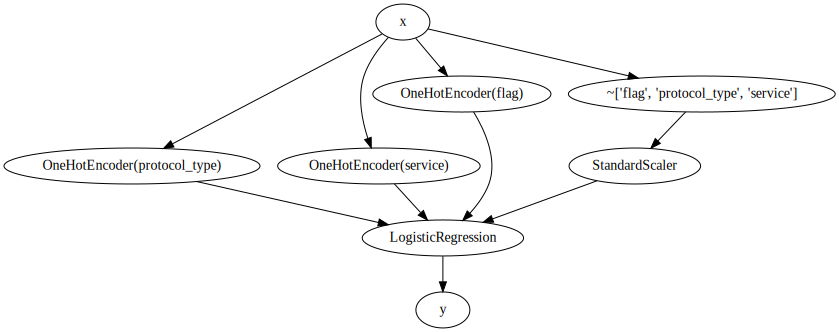

In [73]:
string_processor = (compose.TransformerUnion([preprocessing.OneHotEncoder(col) for col in cols_string]))
num_processor = compose.Blacklister(*cols_string)|preprocessing.StandardScaler()
model =  num_processor + string_processor
model |= linear_model.LogisticRegression()
model.draw()

In [74]:
df.shape

(974031, 11)

In [67]:
# rocauc=metrics.ROCAUC()
cm = metrics.ConfusionMatrix()
recall = metrics.Recall()
f1 = metrics.F1()
precision = metrics.Precision()

In [69]:
# Run
counter=0
for x,y in datastream:
    if counter%10000 == 0:
        print(f"Current iteration: {counter}")

    y_pred = model.predict_one(x)
    if y_pred == y == 1:
        print("gottem")
    
#     rocauc.update(y, y_pred)
    cm.update(y, y_pred)
    recall.update(y, y_pred)
    f1.update(y, y_pred)
    precision.update(y, y_pred)
    
    model.fit_one(x, y)
    counter+=1
# print(rocauc)
# print(cm)
print(recall)
print(f1)
print(precision)

Current iteration: 0
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Current iteration: 60000
Current iteration: 70000
Current iteration: 80000
Current iteration: 90000
Current iteration: 100000
Current iteration: 110000
Current iteration: 120000
Current iteration: 130000
Current iteration: 140000
Current iteration: 150000
Current iteration: 160000
Current iteration: 170000
Current iteration: 180000
Current iteration: 190000
Current iteration: 200000
Current iteration: 210000
Current iteration: 220000
Current iteration: 230000
Current iteration: 240000
Current iteration: 250000
Current iteration: 260000
Current iteration: 270000
Current iteration: 280000
Current iteration: 290000
Current iteration: 300000
Current iteration: 310000
Current iteration: 320000
Current iteration: 330000
Current iteration: 340000
Current iteration: 350000
Current iteration: 360000
Current iteration: 370000
Current iteration: 380000


In [75]:
cm

                   0         1
         0  972527.0         0
         1    1500.0         0

This is a disaster! Not a single malicious instance is correctly classified. In hindsight it is not that surprising that this model failed to learn what constituted malware. The target class was extremely rare, so the logistic regression was perfectly happy just mispredicting 0.17% of the dataset.

In the next notebook, we will look at using 